##### Copyright 2018 The TensorFlow Authors.

In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Transfert de style neuronnal




<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/tutorials/generative/style_transfer"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/generative/style_transfer.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/docs/blob/master/site/en/tutorials/generative/style_transfer.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/docs/site/en/tutorials/generative/style_transfer.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
  <td>
    <a href="https://tfhub.dev/google/magenta/arbitrary-image-stylization-v1-256/2"><img src="https://www.tensorflow.org/images/hub_logo_32px.png" />See TF Hub model</a>
  </td>
</table>

**Ce notebook est une version modifiée et commentée en francais du notebook explicatif du transfert de style neuronnal créé par TensorFlow** par Barbier Loïc

Le transfert de style neuronnal est une technique permettant d'appliquer le style d'une image au contenu d'un autre image. Cette méthode utilise des réseau de neuronne convolutif pour effectuer les transformations sur l'image de contenue

Par exemple, prenons l'image de ce chien et la 7ème composition de Wassily Kandinsky:

<img src="https://storage.googleapis.com/download.tensorflow.org/example_images/YellowLabradorLooking_new.jpg" width="500px"/>

[Yellow Labrador Looking](https://commons.wikimedia.org/wiki/File:YellowLabradorLooking_new.jpg), from Wikimedia Commons by [Elf](https://en.wikipedia.org/wiki/User:Elf). License [CC BY-SA 3.0](https://creativecommons.org/licenses/by-sa/3.0/deed.en)

<img src="https://storage.googleapis.com/download.tensorflow.org/example_images/Vassily_Kandinsky%2C_1913_-_Composition_7.jpg" width="500px"/>


Maintenant, a quoi pourrait ressembler ce chien si Kandinsky décidait de le peindre dans ce style ? Quelque chose comme ceci ?

<img src="https://tensorflow.org/tutorials/generative/images/stylized-image.png" style="width: 500px;"/>

## Setup


### Importation et configuration des modules

La première ligne importe le module "os", qui fournit une manière portable d'utiliser les fonctionnalités liées au système d'exploitation telles que la création de dossiers, la suppression de fichiers, etc.

La deuxième ligne importe le module "tensorflow" en tant que "tf". TensorFlow est une bibliothèque pour l'apprentissage automatique et l'intelligence artificielle.

In [ ]:
import os
import tensorflow as tf

Ce code importe plusieurs modules pour effectuer des opérations de visualisation d'images à l'aide de Python.

La première ligne importe le module "IPython.display" sous l'alias "display". Ce module fournit des fonctions pour afficher des objets dans un notebook Jupyter.

Les deux lignes suivantes importent le module "matplotlib.pyplot" en tant que "plt" et le module "matplotlib" en tant "mpl". Ces modules fournissent des outils de visualisation de données, tels que des graphiques et des images.

Les deux lignes suivantes définissent la taille par défaut de la figure et désactivent les grilles pour les tracés dans Matplotlib.

La ligne suivante importe le module "numpy" en tant que "np". Ce module fournit des fonctions pour effectuer des opérations mathématiques et numériques.

La ligne suivante importe le module "PIL.Image". Ce module fournit des fonctions pour travailler avec des images dans Python.

La ligne suivante importe le module "time". Ce module fournit des fonctions pour travailler avec des temps et des dates dans Python.

La dernière ligne importe le module "functools". Ce module fournit des fonctions pour travailler avec des fonctions dans Python.

In [ ]:
import IPython.display as display

import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (12, 12)
mpl.rcParams['axes.grid'] = False

import numpy as np
import PIL.Image
import time
import functools

La fonction "tensor_to_image" prend un tenseur en entrée et renvoie une image PIL.

La première ligne multiplie chaque élément du tenseur par 255, car les valeurs de pixel de l'image sont souvent représentées par des entiers entre 0 et 255.

La deuxième ligne convertit le tenseur en un tableau NumPy de type uint8, ce qui signifie que chaque élément est représenté par un entier non signé sur 8 bits.

La troisième ligne vérifie si le tenseur a plus de 3 dimensions, ce qui signifie qu'il contient plusieurs images. Si c'est le cas, il vérifie que la première dimension du tenseur est égale à 1, puis supprime cette dimension.

La dernière ligne crée une image PIL à partir du tableau NumPy.

In [ ]:
def tensor_to_image(tensor):
  tensor = tensor*255
  tensor = np.array(tensor, dtype=np.uint8)
  if np.ndim(tensor)>3:
    assert tensor.shape[0] == 1
    tensor = tensor[0]
  return PIL.Image.fromarray(tensor)

Ces deux lignes de code utilisent la fonction "tf.keras.utils.get_file" pour télécharger des images à partir d'Internet et les stocker localement.

La première ligne télécharge l'image de contenu à partir de l'URL spécifiée et la stocke localement sous le nom du premier argument de la fonction. Toutes les inforamtions de cette fonction sont stockées dans la variable "content_path".

La deuxième ligne télécharge l'image de style à partir de l'URL spécifiée et la stocke localement sous le nom du premier argument de la fonction. Toutes les inforamtions de cette fonction sont stockées dans la variable "style_path".

In [ ]:
content_path = tf.keras.utils.get_file('kylian.jpg', 'https://www.planetsport.com/image-library/square/500/k/kylian-mbappe-psg-france-3-april-2022.jpg')
style_path = tf.keras.utils.get_file('sanji.jpg','https://i.pinimg.com/564x/72/47/7e/72477efe7c5a58b29490f22c1eb55a43.jpg')

63808/63808 [==============================] - 0s 0us/step


## Visualiser les entrées

Cette fonction est utilisée pour charger une image à partir d'un fichier spécifié par "path_to_img" et la prétraiter pour qu'elle puisse être utilisée comme entrée pour un modèle TensorFlow.

Tout d'abord, la fonction lit le fichier d'image en utilisant la fonction "tf.io.read_file" et décode l'image en utilisant la fonction "tf.image.decode_image". L'image est convertie en type de données flottant (float32) à l'aide de la fonction "tf.image.convert_image_dtype".

Ensuite, la fonction redimensionne l'image pour que sa plus grande dimension ne dépasse pas 512 pixels, tout en préservant son rapport hauteur/largeur d'origine. Pour ce faire, elle calcule la plus grande dimension de l'image d'origine, puis calcule le facteur d'échelle nécessaire pour que cette dimension soit égale à 512. Elle applique ensuite ce facteur d'échelle pour calculer la nouvelle taille de l'image, puis redimensionne l'image à cette nouvelle taille à l'aide de la fonction "tf.image.resize".

Enfin, la fonction ajoute une dimension supplémentaire à l'image à l'aide de la méthode "tf.newaxis" pour qu'elle corresponde aux exigences d'entrée de certains modèles TensorFlow.

In [ ]:
def load_img(path_to_img):
  max_dim = 512
  img = tf.io.read_file(path_to_img)
  img = tf.image.decode_image(img, channels=3)
  img = tf.image.convert_image_dtype(img, tf.float32)

  shape = tf.cast(tf.shape(img)[:-1], tf.float32)
  long_dim = max(shape)
  scale = max_dim / long_dim

  new_shape = tf.cast(shape * scale, tf.int32)

  img = tf.image.resize(img, new_shape)
  img = img[tf.newaxis, :]
  return img

Cette fonction prend une image sous forme de tenseur TensorFlow et l'affiche à l'aide de la bibliothèque Matplotlib.

La fonction vérifie d'abord si l'image a une dimension supplémentaire, qui est ajoutée lors du prétraitement de l'image à l'aide de la fonction "load_img". Si l'image a une dimension supplémentaire, elle est supprimée à l'aide de la méthode "tf.squeeze" pour qu'elle puisse être affichée correctement par Matplotlib.

Ensuite, la fonction utilise la méthode "plt.imshow" de Matplotlib pour afficher l'image, et si un titre est spécifié, elle utilise également la méthode "plt.title" pour afficher le titre de l'image.

In [ ]:
def imshow(image, title=None):
  if len(image.shape) > 3:
    image = tf.squeeze(image, axis=0)

  plt.imshow(image)
  if title:
    plt.title(title)

Ces lignes de code chargent les images de contenu et de style en utilisant la fonction "load_img" précédemment définie. Ensuite, ils utilisent la fonction "imshow" pour afficher les images de contenu et de style côte à côte dans un subplot de Matplotlib.

La première ligne de code charge l'image de contenu en utilisant le chemin d'accès spécifié dans la variable "content_path", et la deuxième ligne de code charge l'image de style en utilisant le chemin d'accès spécifié dans la variable "style_path".

Ensuite, les deux images sont affichées côte à côte dans un subplot en utilisant la fonction "plt.subplot". La première image est affichée dans le subplot de gauche avec un titre "Image de Contenu", et la deuxième image est affichée dans le subplot de droite avec un titre "Image de Style".

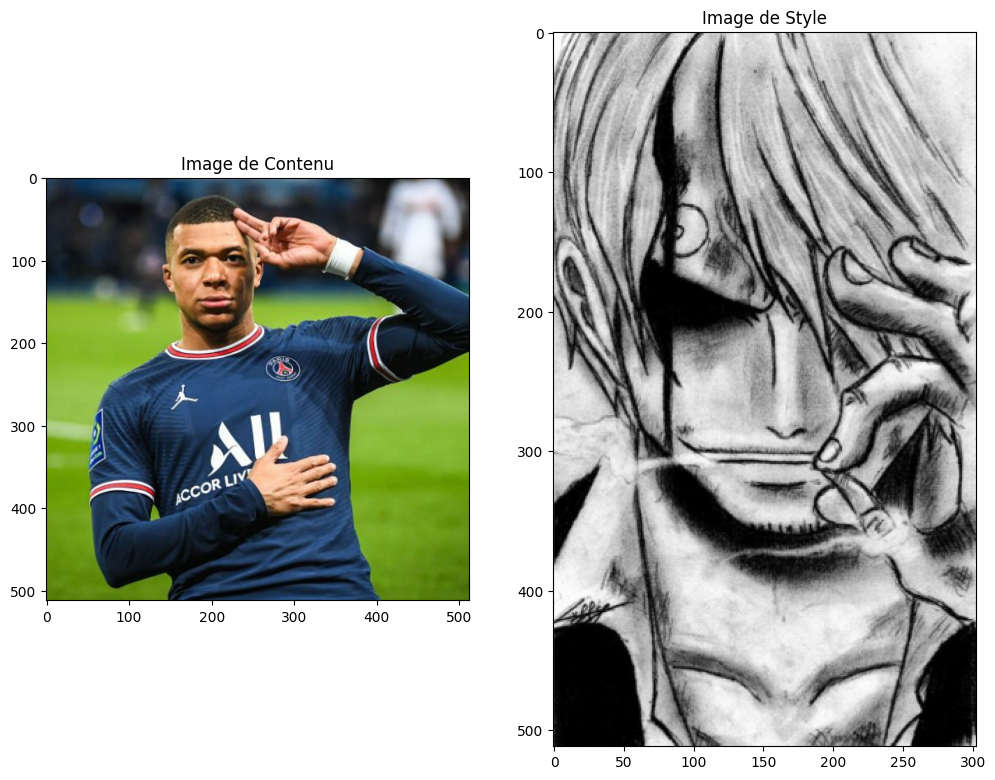

In [ ]:
content_image = load_img(content_path)
style_image = load_img(style_path)

plt.subplot(1, 2, 1)
imshow(content_image, 'Image de Contenu')

plt.subplot(1, 2, 2)
imshow(style_image, 'Image de Style')

## Définir la représentation du contenu et du style

Nous allons ici charger un modèle VGG19 qui nous servira à définir la représentation du contenu et du style




Dans ces lignes de code, l'image de contenu est préparée pour être utilisée avec le modèle VGG19 en appliquant la fonction "preprocess_input" du module Keras sur l'image multipliée par 255.

Ensuite, l'image est redimensionnée en utilisant la fonction "resize" du module TensorFlow, de sorte qu'elle soit compatible avec la taille d'entrée requise par le modèle VGG19.

Ensuite, le modèle VGG19 est chargé à partir de la bibliothèque Keras et la prédiction des probabilités est effectuée en utilisant l'image prétraitée en entrée.

La forme de "prediction_probabilities.shape" donne la taille de la sortie du modèle, qui dépend du nombre de classes dans le jeu de données ImageNet utilisé pour entraîner le modèle. Dans ce cas, la sortie est un tenseur de forme (1, 1000), car le modèle VGG19 est entraîné pour reconnaître 1000 classes d'images différentes.

In [ ]:
x = tf.keras.applications.vgg19.preprocess_input(content_image*255)
x = tf.image.resize(x, (224, 224))
vgg = tf.keras.applications.VGG19(include_top=True, weights='imagenet')
prediction_probabilities = vgg(x)
prediction_probabilities.shape

574710816/574710816 [==============================] - 7s 0us/step


TensorShape([1, 1000])

Ces lignes de code utilisent la fonction "decode_predictions" du module Keras pour décoder les probabilités de prédiction renvoyées par le modèle VGG19. Cette fonction renvoie une liste des cinq classes d'images les plus probables pour l'image de contenu donnée, avec leur nom de classe et leur probabilité associée.

La variable "predicted_top_5" stocke les cinq classes d'images les plus probables pour l'image de contenu.

Enfin, la dernière ligne de code affiche les noms des classes d'images et leurs probabilités associées sous forme de liste, en utilisant une compréhension de liste pour extraire le nom et la probabilité de chaque élément de "predicted_top_5".

In [ ]:
predicted_top_5 = tf.keras.applications.vgg19.decode_predictions(prediction_probabilities.numpy())[0]
[(class_name, prob) for (number, class_name, prob) in predicted_top_5]

35363/35363 [==============================] - 0s 0us/step


[('rugby_ball', 0.4897),
 ('ballplayer', 0.26454246),
 ('baseball', 0.18686554),
 ('football_helmet', 0.030878881),
 ('soccer_ball', 0.02577526)]

Ces lignes de code chargent le modèle VGG19 pré-entraîné sur ImageNet en utilisant les poids 'imagenet' et en spécifiant "include_top=False" pour exclure les couches fully-connected de la sortie du modèle.

Ensuite, le code affiche le nom de chaque couche du modèle VGG19

In [ ]:
vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')

print()
for layer in vgg.layers:
  print(layer.name)

80134624/80134624 [==============================] - 1s 0us/step

input_2
block1_conv1
block1_conv2
block1_pool
block2_conv1
block2_conv2
block2_pool
block3_conv1
block3_conv2
block3_conv3
block3_conv4
block3_pool
block4_conv1
block4_conv2
block4_conv3
block4_conv4
block4_pool
block5_conv1
block5_conv2
block5_conv3
block5_conv4
block5_pool


Ces lignes de code définissent les couches du modèle VGG19 à utiliser pour extraire le contenu et le style de l'image d'entrée.

La liste "content_layers" contient les couches du modèle VGG19 qui seront utilisée pour extraire le contenu de l'image d'entrée.

La liste "style_layers" contient les couches du modèle VGG19 qui seront utilisées pour extraire le style de l'image d'entrée.

Les variables "num_content_layers" et "num_style_layers" contiennent respectivement le nombre de couches à utiliser pour extraire le contenu et le style de l'image d'entrée.

In [ ]:
content_layers = ['block5_conv2'] 

style_layers = ['block1_conv1',
                'block2_conv1',
                'block3_conv1', 
                'block4_conv1', 
                'block5_conv1']

num_content_layers = len(content_layers)
num_style_layers = len(style_layers)

#### Intermediate layers for style and content

So why do these intermediate outputs within our pretrained image classification network allow us to define style and content representations?

At a high level, in order for a network to perform image classification (which this network has been trained to do), it must understand the image. This requires taking the raw image as input pixels and building an internal representation that converts the raw image pixels into a complex understanding of the features present within the image.

This is also a reason why convolutional neural networks are able to generalize well: they’re able to capture the invariances and defining features within classes (e.g. cats vs. dogs) that are agnostic to background noise and other nuisances. Thus, somewhere between where the raw image is fed into the model and the output classification label, the model serves as a complex feature extractor. By accessing intermediate layers of the model, you're able to describe the content and style of input images.

## Création du modèle


La fonction vgg_layers crée un modèle VGG qui retourne une liste des valeurs de sortie intermédiaires pour les noms de couche donnés en entrée. Elle charge le modèle VGG pré-entraîné sur les données ImageNet, et rend les couches non entraînables. Elle retourne un modèle Keras qui prend en entrée les images et renvoie les sorties des couches spécifiées.

In [ ]:
def vgg_layers(layer_names):
  """ Creates a VGG model that returns a list of intermediate output values."""
  # Load our model. Load pretrained VGG, trained on ImageNet data
  vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')
  vgg.trainable = False
  
  outputs = [vgg.get_layer(name).output for name in layer_names]

  model = tf.keras.Model([vgg.input], outputs)
  return model

Et pour créer le modèle:

Nous avons créé un extracteur de style en utilisant la fonction vgg_layers que nous avons définie précédemment. Nous avons ensuite appliqué l'extracteur de style à l'image de style que nous avons chargée. Cela nous donne la sortie de chaque couche spécifiée dans style_layers pour l'image de style.

Ensuite, nous avons imprimé les statistiques de sortie pour chaque couche en bouclant à travers style_layers et en utilisant la fonction zip pour associer chaque couche à sa sortie respective. Cela nous permet de voir les dimensions de chaque sortie de couche, ainsi que les valeurs minimales, maximales et moyennes.

In [ ]:
style_extractor = vgg_layers(style_layers)
style_outputs = style_extractor(style_image*255)

#Look at the statistics of each layer's output
for name, output in zip(style_layers, style_outputs):
  print(name)
  print("  shape: ", output.numpy().shape)
  print("  min: ", output.numpy().min())
  print("  max: ", output.numpy().max())
  print("  mean: ", output.numpy().mean())
  print()

block1_conv1
  shape:  (1, 512, 303, 64)
  min:  0.0
  max:  850.1324
  mean:  30.507267

block2_conv1
  shape:  (1, 256, 151, 128)
  min:  0.0
  max:  3701.6155
  mean:  194.70596

block3_conv1
  shape:  (1, 128, 75, 256)
  min:  0.0
  max:  10433.004
  mean:  184.2064

block4_conv1
  shape:  (1, 64, 37, 512)
  min:  0.0
  max:  19016.162
  mean:  675.49005

block5_conv1
  shape:  (1, 32, 18, 512)
  min:  0.0
  max:  2208.2305
  mean:  47.644947



## Calculer le style

Le contenu d'une image est représenté par les valeurs des cartes de caractéristiques intermédiaires.

Il s'avère que le style d'une image peut être décrit par les moyennes et les corrélations entre les différentes cartes de caractéristiques. Pour calculer une matrice de Gram qui inclut cette information, il faut prendre le produit extérieur du vecteur de caractéristiques avec lui-même à chaque emplacement, et faire la moyenne de ce produit extérieur sur tous les emplacements. Cette matrice de Gram peut être calculée pour une couche particulière comme suit :

$$G^l_{cd} = \frac{\sum_{ij} F^l_{ijc}(x)F^l_{ijd}(x)}{IJ}$$

Cela peut être implémenté en utilisant la fonction `tf.linalg.einsum`

La fonction gram_matrix calcule la matrice de Gram d'un tenseur d'entrée. Cette matrice est utilisée pour mesurer les corrélations entre les différentes "features" extraites d'une image. La fonction prend en entrée un tenseur et renvoie la matrice de Gram correspondante.

Plus précisément, elle utilise la fonction einsum de TensorFlow pour effectuer un produit tensoriel entre le tenseur d'entrée et sa transposée, puis divise le résultat par le nombre total de "locations" (c'est-à-dire le nombre de pixels dans l'image). Cela donne la matrice de Gram normalisée, qui est une mesure de la corrélation spatiale des "features" extraites du tenseur d'entrée.

In [ ]:
def gram_matrix(input_tensor):
  result = tf.linalg.einsum('bijc,bijd->bcd', input_tensor, input_tensor)
  input_shape = tf.shape(input_tensor)
  num_locations = tf.cast(input_shape[1]*input_shape[2], tf.float32)
  return result/(num_locations)

## Extraire le style et le contenu


La classe StyleContentModel est utilisée pour extraire à la fois les caractéristiques de style et de contenu d'une image. Elle hérite de la classe tf.keras.models.Model et définit un modèle qui contient les couches VGG spécifiées pour extraire les caractéristiques de style et de contenu.

Dans la méthode __init__(), les couches VGG sont chargées et seules les couches spécifiées dans style_layers et content_layers sont conservées. num_style_layers est le nombre de couches de style et vgg.trainable est défini sur False pour éviter que le modèle ne soit entraîné.

La méthode call() est la méthode principale de la classe. Elle prend en entrée une image et renvoie un dictionnaire avec les caractéristiques de style et de contenu de cette image. La méthode commence par prétraiter l'entrée en la multipliant par 255. Ensuite, elle calcule les sorties des couches VGG spécifiées et les divise en sorties de style et de contenu. Les sorties de style sont ensuite converties en matrices de Gram et stockées dans un dictionnaire. Les sorties de contenu sont également stockées dans un dictionnaire. Enfin, les deux dictionnaires sont renvoyés comme une sortie de la méthode call().

In [ ]:
class StyleContentModel(tf.keras.models.Model):
  def __init__(self, style_layers, content_layers):
    super(StyleContentModel, self).__init__()
    self.vgg = vgg_layers(style_layers + content_layers)
    self.style_layers = style_layers
    self.content_layers = content_layers
    self.num_style_layers = len(style_layers)
    self.vgg.trainable = False

  def call(self, inputs):
    "Expects float input in [0,1]"
    inputs = inputs*255.0
    preprocessed_input = tf.keras.applications.vgg19.preprocess_input(inputs)
    outputs = self.vgg(preprocessed_input)
    style_outputs, content_outputs = (outputs[:self.num_style_layers],
                                      outputs[self.num_style_layers:])

    style_outputs = [gram_matrix(style_output)
                     for style_output in style_outputs]

    content_dict = {content_name: value
                    for content_name, value
                    in zip(self.content_layers, content_outputs)}

    style_dict = {style_name: value
                  for style_name, value
                  in zip(self.style_layers, style_outputs)}

    return {'content': content_dict, 'style': style_dict}

Ici, nous avons créé une instance de la classe StyleContentModel que nous avons définie précédemment et nous avons appelé cette instance avec l'image de contenu.

Nous avons ensuite imprimé les statistiques de sortie pour chaque couche de style et de contenu en utilisant la méthode items() de l'objet results qui est renvoyé par la méthode call de la classe StyleContentModel. Cela nous permet de voir les caractéristiques de style et de contenu capturées par chaque couche.

Le premier bloc de code imprimera les statistiques pour chaque couche de style et le deuxième bloc de code imprimera les statistiques pour chaque couche de contenu.

In [ ]:
extractor = StyleContentModel(style_layers, content_layers)

results = extractor(tf.constant(content_image))

print('Styles:')
for name, output in sorted(results['style'].items()):
  print("  ", name)
  print("    shape: ", output.numpy().shape)
  print("    min: ", output.numpy().min())
  print("    max: ", output.numpy().max())
  print("    mean: ", output.numpy().mean())
  print()

print("Contents:")
for name, output in sorted(results['content'].items()):
  print("  ", name)
  print("    shape: ", output.numpy().shape)
  print("    min: ", output.numpy().min())
  print("    max: ", output.numpy().max())
  print("    mean: ", output.numpy().mean())


Styles:
   block1_conv1
    shape:  (1, 64, 64)
    min:  0.022021694
    max:  18742.059
    mean:  615.35297

   block2_conv1
    shape:  (1, 128, 128)
    min:  0.0
    max:  95751.9
    mean:  15955.196

   block3_conv1
    shape:  (1, 256, 256)
    min:  0.4659586
    max:  394911.12
    mean:  19356.824

   block4_conv1
    shape:  (1, 512, 512)
    min:  0.0
    max:  4459441.5
    mean:  236990.6

   block5_conv1
    shape:  (1, 512, 512)
    min:  0.0
    max:  109092.336
    mean:  2094.8345

Contents:
   block5_conv2
    shape:  (1, 32, 32, 512)
    min:  0.0
    max:  1708.7792
    mean:  17.75128


## Calcul de la perte


Les lignes de code suivantes définissent les cibles de style et de contenu pour l'image de style et l'image de contenu respectivement. Le modèle extractor est utilisé pour extraire les caractéristiques de style et de contenu à partir des images de style et de contenu. Les sorties de style et de contenu sont stockées dans style_targets et content_targets respectivement. Les sorties du modèle pour l'image de style sont les cibles de style et les sorties du modèle pour l'image de contenu sont les cibles de contenu. Ces cibles seront utilisées pour calculer les pertes de style et de contenu lors de la formation de l'image générée.

In [ ]:
style_targets = extractor(style_image)['style']
content_targets = extractor(content_image)['content']

Cette ligne de code crée une variable TensorFlow appelée image qui est initialisée avec l'image de contenu. Cette variable sera optimisée pour générer une nouvelle image qui combine le contenu de l'image de contenu et le style de l'image de style.

In [ ]:
image = tf.Variable(content_image)

Vue que l'image est composé de float allant de 0 à 1, on défini la fonction suivante qui prend une image en entrée et renvoie l'image après l'avoir "clampée" entre 0 et 1. Cela signifie que tous les pixels dont la valeur est inférieure à 0 seront réglés à 0, et tous les pixels dont la valeur est supérieure à 1 seront réglés à 1.

In [ ]:
def clip_0_1(image):
  return tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0)

Les variables style_weight et content_weight sont utilisées pour ajuster l'importance relative de la perte de style et de la perte de contenu dans la fonction de coût totale. En ajustant ces valeurs, on peut contrôler l'apparence de la sortie générée par l'algorithme de transfert de style.

In [ ]:
style_weight=1e-2
content_weight=1e4

La fonction style_content_loss(outputs) calcule la perte totale du modèle. Cette fonction prend en entrée les sorties de l'extracteur de style et de contenu.

La perte de style est calculée en comparant les matrices de Gram de chaque couche de sortie de style à celles des cibles de style. Cela est fait en bouclant sur chaque couche de style, en calculant la différence de matrice de Gram, en prenant le carré de la différence et en faisant la moyenne de tous les éléments de la matrice. La perte de style est pondérée par le poids de style et le nombre de couches de style.

La perte de contenu est calculée de manière similaire en comparant les sorties de contenu à celles des cibles de contenu. La perte de contenu est pondérée par le poids de contenu et le nombre de couches de contenu.

La fonction retourne la somme des pertes de style et de contenu.


In [ ]:
def style_content_loss(outputs):
    style_outputs = outputs['style']
    content_outputs = outputs['content']
    style_loss = tf.add_n([tf.reduce_mean((style_outputs[name]-style_targets[name])**2) 
                           for name in style_outputs.keys()])
    style_loss *= style_weight / num_style_layers

    content_loss = tf.add_n([tf.reduce_mean((content_outputs[name]-content_targets[name])**2) 
                             for name in content_outputs.keys()])
    content_loss *= content_weight / num_content_layers
    loss = style_loss + content_loss
    return loss

## La perte de variation totale


Cette fonction prend une image en entrée et renvoie les variations de haute fréquence dans les directions horizontale et verticale. Elle calcule ces variations en soustrayant les valeurs de pixel adjacentes de l'image d'entrée. Les variations horizontales sont calculées en soustrayant les valeurs de pixel dans les colonnes adjacentes, tandis que les variations verticales sont calculées en soustrayant les valeurs de pixel dans les lignes adjacentes.

In [ ]:
def high_pass_x_y(image):
  x_var = image[:, :, 1:, :] - image[:, :, :-1, :]
  y_var = image[:, 1:, :, :] - image[:, :-1, :, :]

  return x_var, y_var

La fonction total_variation_loss calcule la perte de variation totale d'une image. Cette perte mesure à quel point l'image est régulière et lisse, en contrôlant la variation entre les pixels voisins. Pour cela, la fonction calcule les différences horizontales et verticales entre les pixels de l'image à l'aide de la fonction high_pass_x_y, puis elle somme les valeurs absolues de ces différences pour obtenir la perte totale.

In [ ]:
def total_variation_loss(image):
  x_deltas, y_deltas = high_pass_x_y(image)
  return tf.reduce_sum(tf.abs(x_deltas)) + tf.reduce_sum(tf.abs(y_deltas))

Cette ligne de code calcule et retourne la perte de variation totale pour la variable image. La perte de variation totale est utilisée dans le processus de formation de style de l'image pour encourager une image lisse en réduisant le bruit et les artefacts indésirables. La méthode numpy est utilisée pour extraire la valeur de perte de variation totale sous forme de tableau NumPy.

In [ ]:
total_variation_loss(image).numpy()

28899.496

Il est à noter que l'implémentation de la fonction "total_variation_loss" n'est présente qu'a titre indicatif et explicatif car il existe une fonction dans la librairie TensorFlow qui effectue ce calcul. Cette fonction est la suivante :

In [ ]:
tf.image.total_variation(image).numpy()

array([28899.496], dtype=float32)

La variable total_variation_weight est utilisée pour pondérer l'importance de la perte de variation totale par rapport à la perte de style et de contenu.

In [ ]:
total_variation_weight=30

## Lancer l'entrainement

Cette fonction train_step a pour but d'effectuer une itération d'entraînement du modèle de style de transfert.

La fonction est décorée avec @tf.function, ce qui signifie qu'elle sera compilée en un graphe TensorFlow pour une exécution plus rapide.

À chaque itération, la fonction calcule les sorties du modèle pour l'image donnée en entrée, puis calcule la perte de style et de contenu à partir de ces sorties.

La fonction ajoute également une perte de variation totale à la perte totale. La perte de variation totale mesure la quantité de bruit dans l'image, ce qui permet de réduire le bruit dans l'image générée.

Ensuite, la fonction calcule les gradients de la perte totale par rapport à l'image et utilise l'optimiseur pour mettre à jour l'image.

Enfin, la fonction utilise la fonction clip_0_1 pour s'assurer que les valeurs de l'image sont comprises entre 0 et 1.

In [ ]:
@tf.function()
def train_step(image):
  with tf.GradientTape() as tape:
    outputs = extractor(image)
    loss = style_content_loss(outputs)
    loss += total_variation_weight*tf.image.total_variation(image)

  grad = tape.gradient(loss, image)
  opt.apply_gradients([(grad, image)])
  image.assign(clip_0_1(image))

Ces deux lignes de code définissent un optimiseur et initialisent une variable d'image avec l'image de contenu. L'optimiseur utilisé est Adam, un algorithme d'optimisation stochastique populaire pour l'apprentissage profond. La vitesse d'apprentissage est de 0,02, le coefficient beta_1 est de 0,99 et l'epsilon est de 1e-1. La variable d'image est reinitialisée avec l'image de contenu, qui sera progressivement modifiée au cours de l'entraînement pour se rapprocher de l'image stylisée souhaitée.

In [ ]:
opt = tf.keras.optimizers.Adam(learning_rate=0.02, beta_1=0.99, epsilon=1e-1)
image = tf.Variable(content_image)

Ces instructions ont pour but de faire une itération de la phase d'entraînement du modèle, en utilisant l'image initiale image pour générer une nouvelle image avec un style plus proche de l'image de style cible.

train_step(image) appelle la fonction train_step définie précédemment pour effectuer une itération de la descente de gradient et mettre à jour l'image image en conséquence.

Enfin, tensor_to_image(image) prend l'image résultante image et la convertit en un format qui peut être affiché

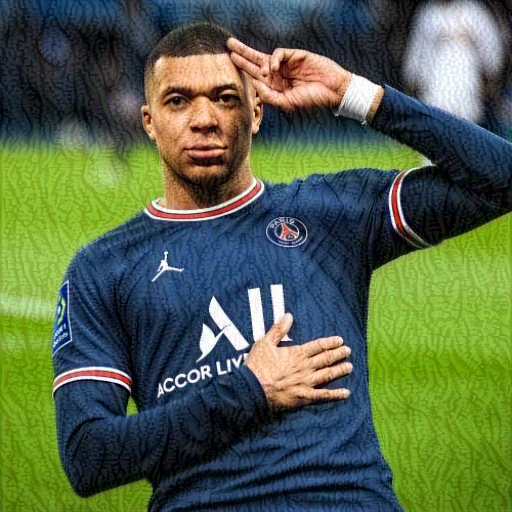

In [ ]:
train_step(image)
train_step(image)
train_step(image)
tensor_to_image(image)

Ce code réalise l'entraînement du modèle de style de transfert sur l'image de contenu en utilisant l'algorithme Adam pour optimiser la perte totale. Le processus est effectué pendant plusieurs époques, chacune avec un nombre défini de pas par époque. Dans chaque pas, le modèle effectue une rétropropagation sur les gradients calculés en utilisant la fonction de perte combinée (style, contenu et variation totale) et met à jour l'image de contenu en conséquence. L'image est également limitée dans l'intervalle [0, 1] à chaque pas pour éviter les valeurs extrêmes.

Une fois que chaque pas est terminé, l'image de contenu mise à jour est affichée et le nombre de pas est imprimé. À la fin de l'entraînement, le temps total écoulé est imprimé.

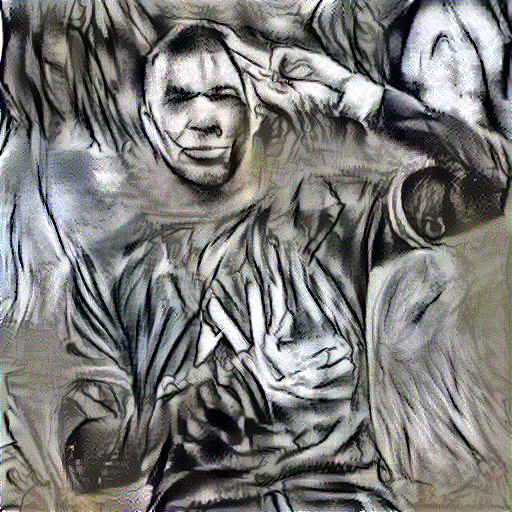

Train step: 1000
Total time: 87.4


In [ ]:
import time
start = time.time()

epochs = 10
steps_per_epoch = 100

step = 0
for n in range(epochs):
  for m in range(steps_per_epoch):
    step += 1
    train_step(image)
    print(".", end='', flush=True)
  display.clear_output(wait=True)
  display.display(tensor_to_image(image))
  print("Train step: {}".format(step))

end = time.time()
print("Total time: {:.1f}".format(end-start))

Le code ci-dessus sauvegarde l'image stylisée sous le nom de fichier "stylized-image.png". Ensuite, il tente de télécharger le fichier en utilisant la bibliothèque "google.colab.files" si elle est disponible. Si la bibliothèque n'est pas disponible, il passe simplement à la suite du code.

In [ ]:
file_name = 'stylized-image.png'
tensor_to_image(image).save(file_name)

try:
  from google.colab import files
except ImportError:
   pass
else:
  files.download(file_name)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>